Goal: get Kalshi data in order to prepare for training in ML model. For each day, if sufficient volume, take 3 markets. I want minute by minute pricing that is smooth and representative. Then I want to save each as a csv. I also want prices for certain times only (i.e. from 9:30 to 4). True price is going to be the ask, since that's what I can buy it for. We will be using s&p data.

Problems with the data:
    1. sometimes times are listed not in order -> check that each succeeding time is in correct order
    2. sometimes prices are wrong (0 bid or 100 ask) -> check for outliers
    3. entries are not regular -> take minute average and then create entries by connecting between values

Plot a day's worth of kalshi price data

In [6]:
import pandas as pd

datapath = '../data_storage/kalshi_data/INXD/23/JUL/12/INXD-23JUL12-B4487.csv'
df = pd.read_csv(datapath)

df['avg'] = (df['bid'] + df['ask']) / 2
df.head()

,datetime,bid,ask,open_interest,volume,avg
0,2023-07-12 09:30:10,26,37,1513,1921,31.5
1,2023-07-12 09:31:00,31,37,1513,1921,34.0
2,2023-07-12 09:31:00,33,37,1513,1921,35.0
3,2023-07-12 09:31:00,34,37,1513,1921,35.5
4,2023-07-12 09:31:08,35,37,1513,1921,36.0


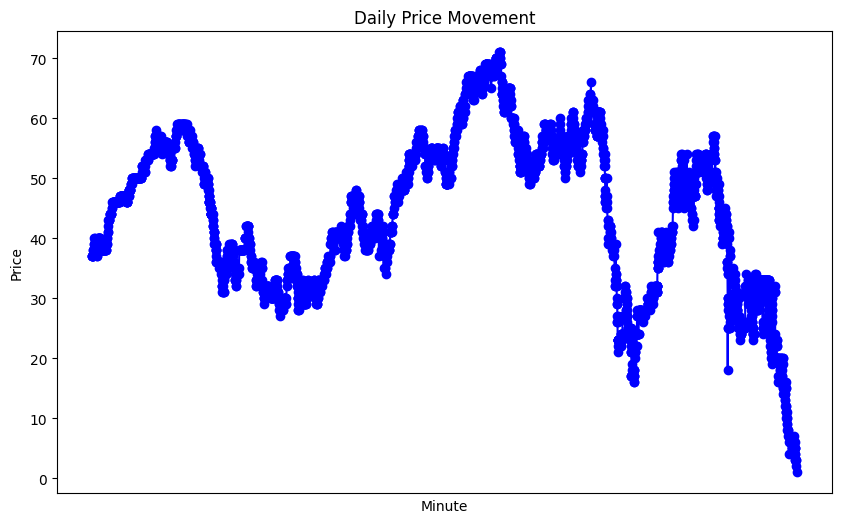

In [7]:
import matplotlib.pyplot as plt

indices = list(range(0, len(df), 60))

plt.figure(figsize=(10, 6))
plt.plot(df['datetime'], df['ask'], marker='o', linestyle='-', color='b')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.xlabel('Minute')
plt.ylabel('Price')
plt.title('Daily Price Movement')

plt.show()

Check if there are reversions in the datetimes

In [8]:
from datetime import datetime as dt
from datetime import timedelta

dts = [pd.to_datetime(entry) for entry in df['datetime'].tolist()]

for i in range(0, len(dts)-1):
    current = dts[i]
    next = dts[i+1]
    if current > next:
        raise Exception('uh oh')

print('done')


done


Get all minutes in the trading day

In [9]:
def generate_trading_times():
    start_time = dt.strptime("09:30", "%H:%M")
    end_time = dt.strptime("15:59", "%H:%M")

    trading_times = []
    current_time = start_time

    while current_time <= end_time:
        trading_times.append(current_time.strftime("%H:%M"))
        current_time += timedelta(minutes=1)

    return trading_times


Create a function that can take in a day's data and make it good for the model

In [10]:
def model_processor(df, threshhold):
    length = len(df)
    if length < threshhold:
        return None
        
    times = generate_trading_times()
    
    columns = {
        'time': 'string',
        'ask': 'int'
    }
    
    modified_df = pd.DataFrame(columns=columns.keys())

    for col, dtype in columns.items():
        modified_df[col] = modified_df[col].astype(dtype)
    
    for entry in times:
        target_time = dt.strptime(entry, "%H:%M")
        target_hour = target_time.hour
        target_minute = target_time.minute
        
        df['datetime'] = pd.to_datetime(df['datetime'])
        hour_mask = df['datetime'].dt.hour == target_hour
        minute_mask = df['datetime'].dt.minute == target_minute
        
        filtered_df = df[hour_mask & minute_mask]
        
        if not filtered_df.empty:
            avg_ask = int(filtered_df['ask'].mean())
            new_row_df = pd.DataFrame({'time': [entry], 'ask': [avg_ask]})
            modified_df = pd.concat([modified_df, new_row_df], ignore_index=True)
            
        else:
            if entry == '09:30':
                ask = int(df.iloc[0]['ask'])
                new_row_df = pd.DataFrame({'time': [entry], 'ask': [ask]})
                modified_df = pd.concat([modified_df, new_row_df], ignore_index=True)
            
            else:
                mask1 = df['datetime'].dt.hour < target_hour
                mask2 = df['datetime'].dt.minute < target_minute
                mask3 = df['datetime'].dt.hour == target_hour
                previous_df = df[mask1 | (mask2 & mask3)]
                if not previous_df.empty:
                    previous_ask = previous_df.iloc[-1]['ask']
                    new_row_df = pd.DataFrame({'time': [entry], 'ask': [previous_ask]})
                    modified_df = pd.concat([modified_df, new_row_df], ignore_index=True)
                else:  
                    raise Exception('error') 
    return modified_df

output = model_processor(df, 0)
output 

,time,ask
0,09:30,37
1,09:31,38
2,09:32,38
3,09:33,39
4,09:34,39
...,...,...
385,15:55,24
386,15:56,16
387,15:57,8
388,15:58,4


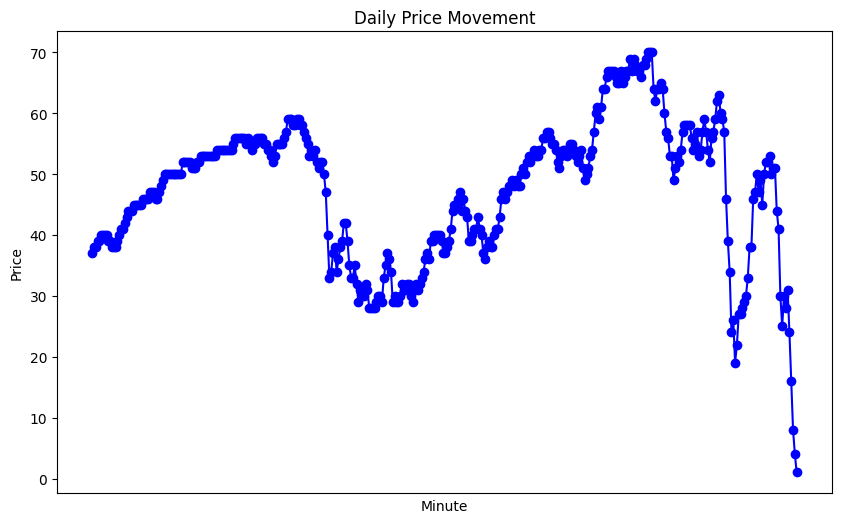

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(output['time'], output['ask'], marker='o', linestyle='-', color='b')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.xlabel('Minute')
plt.ylabel('Price')
plt.title('Daily Price Movement')

plt.show()

First I want to see what a good threshhold would be, so I'm going to look at the lowest threshholds and see if they are reasonable

In [12]:
import os
import pandas as pd

directory_path = '../data_storage/ml_training_data'
all_file_paths = [os.path.join(root, filename) for root, _, files in os.walk(directory_path) for filename in files]

lengths = []
for entry in all_file_paths:
    df = pd.read_csv(entry)
    length = len(df)
    lengths.append((length, entry[50:]))
lengths.sort(key= lambda x: x[0])
print(len(lengths))
lengths
    


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc8 in position 567: invalid continuation byte

Now I have to get all the days data by modifying the OG function to take the new year's data in

Then I can run the function I made above on each file, saving it to a new directory

In [ ]:
# for entry in all_file_paths:
#     df = pd.read_csv(entry)
#     try:
#         modified_df = model_processor(df, 1300)
#     except Exception as e:
#         print(e)
#         continue
#     if modified_df is not None:
#         new_file_path = entry[:32]+ '/revised/' + entry[33:]
#         def safe_open_w(path):
#             os.makedirs(os.path.dirname(path), exist_ok=True)
#             return open(path, 'w')
#         with safe_open_w(new_file_path) as f:
#             modified_df.to_csv(new_file_path, index=False)


                datetime  bid  ask  open_interest  volume
0    2024-04-04 14:20:13    1    2            689     689
1    2024-04-04 14:20:16    0    2            689     689
2    2024-04-04 14:20:20    1    2            689     689
3    2024-04-04 14:20:20    0    2            689     689
4    2024-04-04 14:20:26    1    2            689     689
...                  ...  ...  ...            ...     ...
2284 2024-04-04 15:59:56   70   78          25678   58851
2285 2024-04-04 15:59:56   77   78          25678   58851
2286 2024-04-04 15:59:56   77   78          25738   58911
2287 2024-04-04 15:59:58   77   80          25738   58911
2288 2024-04-04 15:59:59   77   84          25738   58911

[2289 rows x 5 columns]
09:31 0       False
1       False
2       False
3       False
4       False
        ...  
2284    False
2285    False
2286    False
2287    False
2288    False
Name: datetime, Length: 2289, dtype: bool 0        True
1        True
2        True
3        True
4        True
       